In [643]:
import numpy as np

def criaDatasetBidimensionalBinárioInclinado(n=20, slop=[2, 1], intercept=0.4):
    """
    Cria um dataset bidimensional binário com
    inclinação e interceptação do eixo vertical
    parametrizados.
    """
    X = np.random.uniform(size=(n,2))*5
    AUX = np.multiply(X, slop)-[0, intercept]
    y = np.array(AUX[:,0]>AUX[:,1], dtype=int)*2-1
    return X, y

slop = [2, 1]
intercept = -0.4
Xtr, ytr = criaDatasetBidimensionalBinárioInclinado(n=20, slop=slop, intercept=intercept)
Xtr, ytr

(array([[3.32293843, 0.36862065],
        [1.33695724, 1.34688239],
        [2.35945272, 2.26837451],
        [3.1393746 , 3.4095222 ],
        [2.34647064, 2.14674563],
        [0.03137792, 2.18196972],
        [0.02578424, 2.36400477],
        [2.85037858, 1.20483828],
        [1.69222901, 1.84052773],
        [4.20726263, 4.65614142],
        [0.18041223, 3.51915715],
        [4.22596978, 0.18180613],
        [2.85697686, 3.44903687],
        [4.85030306, 1.93122176],
        [3.43829942, 0.00940827],
        [0.83882632, 0.08500735],
        [2.78438359, 1.23623559],
        [0.13799669, 0.70333242],
        [3.77804826, 0.46605038],
        [1.19101752, 0.77526773]]),
 array([ 1,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        -1,  1,  1]))

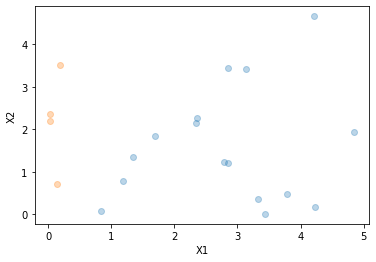

In [644]:
import matplotlib.pyplot as plt

def plotaDatasetBidimensional(X, y):
    """
    Plota um dataset bidimensional.
    """
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

plotaDatasetBidimensional(Xtr, ytr)

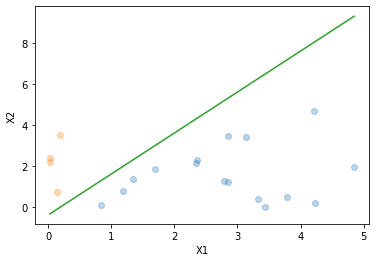

In [645]:
def plotaHiperplanoDatasetBidimensional(X, y, vetor, intercept=0):
    """
    Plota um dataset bidimensional com um hiperplano definido por um
    vetor e o valor em que este vetor intercepta o eixo vertical.
    """
    x0min = min(X[:,0])
    x0max = max(X[:,0])
    xs = np.linspace(x0min, x0max, num=2)
    ys = (-vetor[0] / vetor[1]) * xs - intercept / vetor[1]
    plotaDatasetBidimensional(X, y)
    plt.plot(xs,ys)

vetor_hyperplano = np.array(slop) * np.array([1, -1])
plotaHiperplanoDatasetBidimensional(Xtr, ytr, vetor_hyperplano, intercept)

In [646]:
def sign(a):
    return (a >= 0) * 2 - 1

In [647]:
def accuracy(yactual, ypred):
    return sum(yactual == ypred)/len(yactual)

In [648]:
from abc import ABC, abstractstaticmethod

class Custo(ABC):
    @abstractstaticmethod
    def custo(y, ypred):
        pass
    @abstractstaticmethod
    def gradiente(y, ypred, X):
        pass

class WidrowHoff(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum((1 - (y * ypred))**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return np.matmul(X.T, y - ypred)

class SmoothedSurrogate(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        return np.matmul(X.T, y - sign(ypred))

class HingeLoss(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), 1 - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        errosmarginais = (y * ypred) < 1
        ymarginais = np.copy(y)
        ymarginais[~errosmarginais] = 0
        g = X.T @ ymarginais
        return g

In [649]:
from abc import ABC, abstractmethod

class TrainingAlgorithm(ABC):
    @abstractmethod
    def getW(self, X, y, activation):
        pass

class DescidaGradiente(TrainingAlgorithm):
    def __init__(self, max_iter=1000, learning_rate=0.005, 
                       regularization=0, cost=WidrowHoff()):
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.cost = cost

    def getW(self, X, y):
        w = np.random.uniform(-1, 1, size=X.shape[1])
        for _ in range(self.max_iter):
            ypred = X @ w
            if self.cost.custo(y, ypred) == 0:
                break
            w *= 1 - self.regularization * self.learning_rate
            w += self.cost.gradiente(y, ypred, X) * self.learning_rate
        return w

1.0
[-0.10996134  0.39547104 -0.11223186]
0.18108483043591378


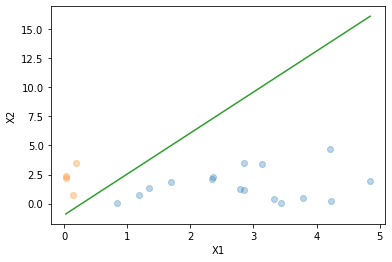

In [650]:
from sklearn.base import BaseEstimator, ClassifierMixin

class Perceptron(BaseEstimator, ClassifierMixin):
    """
    Versão Adaline do Perceptron com limite de iterações,
    treinado em batch, com bias e taxa de aprendizado.
    """
    def __init__(self, training_algrithm=DescidaGradiente()):
        self.w = None
        self.activation = sign
        self.training_algorithm = training_algrithm
    
    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0],1))
        Xb = np.concatenate((bias,X), axis=1)
        return Xb

    def fit(self, X, y):
        Xb = Perceptron.includebias(X)
        self.w = self.training_algorithm.getW(Xb, y)
    
    def __pre_activation(self, X):
        Xb = Perceptron.includebias(X)
        return np.matmul(Xb, self.w)

    def predict(self, X):
        a = self.__pre_activation(X)
        ypred = self.activation(a)
        return ypred

perceptron = Perceptron()
perceptron.fit(Xtr, ytr)
print(accuracy(ytr, perceptron.predict(Xtr)))
print(perceptron.w)
plotaHiperplanoDatasetBidimensional(Xtr, ytr, perceptron.w[1:], perceptron.w[0])
print(sum(perceptron.w**2))


In [651]:
Xte, yte = criaDatasetBidimensionalBinárioInclinado(n=1000, slop=slop, intercept=intercept)

1.0 0.906 [-0.10996135  0.39547104 -0.11223186]


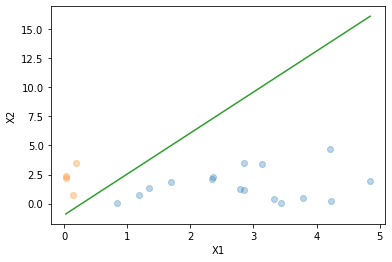

1.0 0.902 [ 0.32944048  0.71916599 -0.61582107]


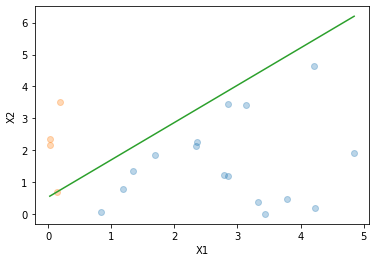

1.0 0.949 [-0.75288447  2.16974453 -0.77940362]


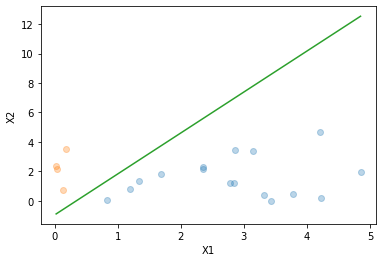

In [652]:
custos = [WidrowHoff(), SmoothedSurrogate(), HingeLoss()]

for custo in custos:
    perceptron = Perceptron(training_algrithm=DescidaGradiente(regularization=0, cost=custo))
    perceptron.fit(Xtr, ytr)
    print(accuracy(ytr, perceptron.predict(Xtr)), accuracy(yte, perceptron.predict(Xte)), perceptron.w)
    plotaHiperplanoDatasetBidimensional(Xtr, ytr, perceptron.w[1:], perceptron.w[0])
    plt.show()
